In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
import random

In [ ]:

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


#1. Loading Data

In [ ]:

df = pd.read_csv(r"D:\polarData\ice_extent_full_dataset.csv")

time_series_features = ["Ice Coverage (%)", "Retreat Area (Since 1979) (%)"]
target_columns = ["Retreat Area (Yearly) (%)"]

df = df.sort_values(["Year", "Image"])

train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)
test_size = len(df) - train_size - val_size

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size+val_size]
test_df = df.iloc[train_size+val_size:]

#  Normalize Data
scaler_tst = StandardScaler()
scaler_target = StandardScaler()

train_tst_features = scaler_tst.fit_transform(train_df[time_series_features])
val_tst_features = scaler_tst.transform(val_df[time_series_features])
test_tst_features = scaler_tst.transform(test_df[time_series_features])

train_targets = scaler_target.fit_transform(train_df[target_columns])
val_targets = scaler_target.transform(val_df[target_columns])
test_targets = scaler_target.transform(test_df[target_columns])

#  Converted to PyTorch Tensors
X_train_tst = torch.tensor(train_tst_features, dtype=torch.float32)
y_train = torch.tensor(train_targets, dtype=torch.float32)

X_val_tst = torch.tensor(val_tst_features, dtype=torch.float32)
y_val = torch.tensor(val_targets, dtype=torch.float32)

X_test_tst = torch.tensor(test_tst_features, dtype=torch.float32)
y_test = torch.tensor(test_targets, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tst, y_train)
val_dataset = TensorDataset(X_val_tst, y_val)
test_dataset = TensorDataset(X_test_tst, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f" Training Data: {len(train_df)} samples")
print(f" Validation Data: {len(val_df)} samples")
print(f" Testing Data: {len(test_df)} samples")


 Training Data: 1049 samples
 Validation Data: 131 samples
 Testing Data: 132 samples


#2. Training RNN

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using Device: {device}")


#  RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, output_dim=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, hidden = self.rnn(x.unsqueeze(1))  # Add sequence dim
        return self.fc(hidden[-1])


# Training with Early Stopping

def train_rnn(model, train_loader, val_loader, optimizer, criterion, epochs=50, patience=5):
    model.train()
    best_val_loss = float("inf")
    epochs_without_improvement = 0

    for epoch in range(epochs):
        total_train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x).squeeze()
            loss = criterion(output, y.squeeze())
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation Step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output = model(x).squeeze()
                val_loss = criterion(output, y.squeeze())
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_rnn_model.pth")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            break

    return best_val_loss


#  Training Final Model

rnn_model = RNNModel(input_dim=2, hidden_dim=128, num_layers=2, dropout=0.2).to(device)
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
best_val_loss = train_rnn(rnn_model, train_loader, val_loader, optimizer, nn.MSELoss())

print(f" Final Best Validation Loss: {best_val_loss:.4f}")

 Using Device: cpu
Epoch 1/50, Train Loss: 0.2949, Validation Loss: 0.1842
Epoch 2/50, Train Loss: 0.1515, Validation Loss: 0.1429
Epoch 3/50, Train Loss: 0.1448, Validation Loss: 0.1336
Epoch 4/50, Train Loss: 0.1322, Validation Loss: 0.1648
Epoch 5/50, Train Loss: 0.1261, Validation Loss: 0.1346
Epoch 6/50, Train Loss: 0.1331, Validation Loss: 0.1539
Epoch 7/50, Train Loss: 0.1279, Validation Loss: 0.1453
Epoch 8/50, Train Loss: 0.1359, Validation Loss: 0.1282
Epoch 9/50, Train Loss: 0.1267, Validation Loss: 0.1772
Epoch 10/50, Train Loss: 0.1259, Validation Loss: 0.1829
Epoch 11/50, Train Loss: 0.1199, Validation Loss: 0.1537
Epoch 12/50, Train Loss: 0.1289, Validation Loss: 0.1441
Epoch 13/50, Train Loss: 0.1299, Validation Loss: 0.1498
 Final Best Validation Loss: 0.1282


#3. Evaluate Model

In [ ]:

#  Evaluate RNN

rnn_model.load_state_dict(torch.load("best_rnn_model.pth"))
rnn_model.eval()

# Predict on Test Set
with torch.no_grad():
    y_pred_test = rnn_model(X_test_tst.to(device)).cpu().numpy()

y_pred_test = scaler_target.inverse_transform(y_pred_test)
y_test_actual = scaler_target.inverse_transform(y_test.numpy())

# Evaluation Metrics
mse = mean_squared_error(y_test_actual, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_test)
r2 = r2_score(y_test_actual, y_pred_test)

print(f"\n **Evaluation for RNN Retreat Area (Yearly) (%):**")
print(f" Mean Squared Error (MSE): {mse:.4f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f" Mean Absolute Error (MAE): {mae:.4f}")
print(f" R² Score: {r2:.4f}")


metrics_df = pd.DataFrame({
    "Model": ["RNN"],
    "MSE": [mse],
    "RMSE": [rmse],
    "MAE": [mae],
    "R² Score": [r2]
})

#  Save Evaluation Metrics to CSV
metrics_csv_path = r"D:\polarData\rnn_evaluation_metrics.csv"
metrics_df.to_csv(metrics_csv_path, index=False)

print(f" Evaluation metrics saved to: {metrics_csv_path}")


 **Evaluation for RNN Retreat Area (Yearly) (%):**
 Mean Squared Error (MSE): 2.3025
 Root Mean Squared Error (RMSE): 1.5174
 Mean Absolute Error (MAE): 1.0364
 R² Score: 0.8363
 Evaluation metrics saved to: D:\polarData\rnn_evaluation_metrics.csv


#4. Save Final Prediction on Test Set in a CSV.

In [ ]:

test_predictions_clean_df = test_df.copy()[["Year"]].copy()

# Add the actual and predicted retreat area values.
test_predictions_clean_df["Actual Retreat Area (Yearly) (%)"] = y_test_actual.flatten()
test_predictions_clean_df["Predicted Retreat Area (Yearly) (%)"] = y_pred_test.flatten()

yearly_predictions_df = test_predictions_clean_df.groupby("Year", as_index=False).mean()

# Saving results to CSV.
test_predictions_csv_path = r"D:\polarData\rnn_test_predictions.csv"
yearly_predictions_df.to_csv(test_predictions_csv_path, index=False)

print(f"Final Test Predictions saved at: {test_predictions_csv_path}")

Final Test Predictions saved at: D:\polarData\rnn_test_predictions.csv


#5. Comparison of Actual and Predicted Retreat Area

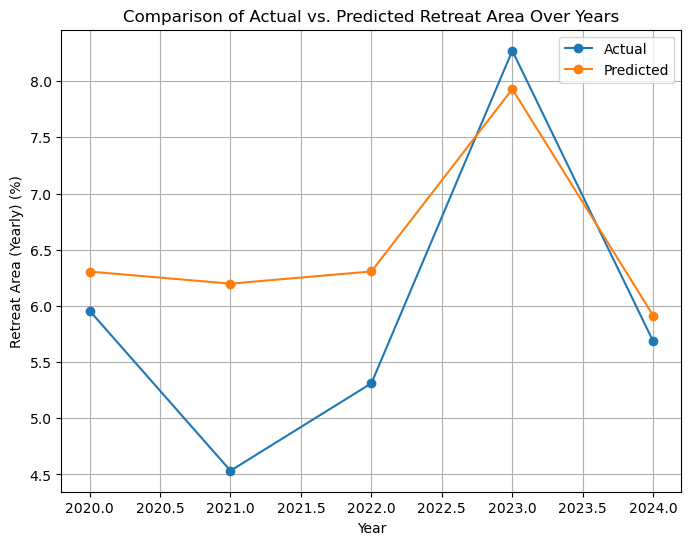

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = r"D:\polarData\rnn_test_predictions.csv"
df = pd.read_csv(csv_path)

plt.figure(figsize=(8, 6))

plt.plot(df["Year"], df["Actual Retreat Area (Yearly) (%)"], label="Actual", marker="o")
plt.plot(df["Year"], df["Predicted Retreat Area (Yearly) (%)"], label="Predicted", marker="o")

plt.xlabel("Year")
plt.ylabel("Retreat Area (Yearly) (%)")
plt.title("Comparison of Actual vs. Predicted Retreat Area Over Years")
plt.legend()
plt.grid(True)

plt.show()



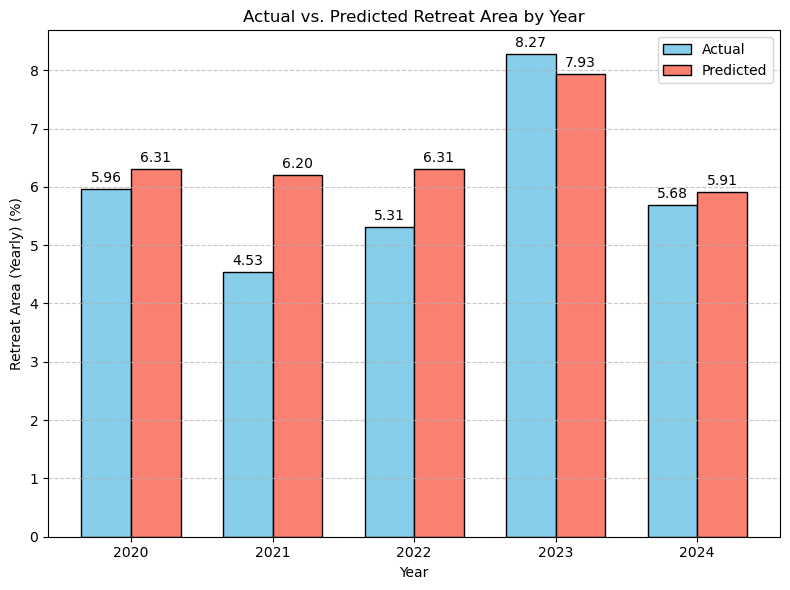

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_path = r"D:\polarData\rnn_test_predictions.csv"
df = pd.read_csv(csv_path)


years = df["Year"].astype(int)
actual_values = df["Actual Retreat Area (Yearly) (%)"]
predicted_values = df["Predicted Retreat Area (Yearly) (%)"]

x = np.arange(len(years))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

rects1 = ax.bar(x - width/2, actual_values, width, label='Actual', color='skyblue', edgecolor='black')

rects2 = ax.bar(x + width/2, predicted_values, width, label='Predicted', color='salmon', edgecolor='black')

ax.set_xlabel('Year')
ax.set_ylabel('Retreat Area (Yearly) (%)')
ax.set_title('Actual vs. Predicted Retreat Area by Year')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),    # offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()
